In [33]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg
from   tomog                 import select_tomog

In [34]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [35]:
def get_clauds(field='COSMOS', stellar_mask=True):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
                
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    clauds[field]    = Table.read('/global/cscratch1/sd/mjwilson/clauds/ChY/COSMOS_CLAUDS_r25.fits')

    # NOTE: MASK==1 for all entries to ChY. 
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    # clauds[field]  = clauds[field][(clauds[field]['MASK'] == 0)] 
    
    # u or uS data.
    inband           = (clauds[field]['FLAG_FIELD_BINARY'][:,1] == True) | (clauds[field]['FLAG_FIELD_BINARY'][:,2] == True)              
    clauds[field]    =  clauds[field][inband]               
    
    # Randomise the rows for security. 
    indices          = np.arange(len(clauds[field]))
    randomised       = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [36]:
tile_radius  = get_tile_radius_deg()
tiles        = Table(io.load_tiles())

In [37]:
clauds, area = get_clauds(field='COSMOS')

In [38]:
print(len(clauds) / 1.e6)

0.699477


In [39]:
# Fix up fake magnitudes outside the observed areas.
clauds['u'][~clauds['FLAG_FIELD_BINARY'][:,1]]=0.
clauds['u_err'][~clauds['FLAG_FIELD_BINARY'][:,1]]=1000.
clauds['uS'][~clauds['FLAG_FIELD_BINARY'][:,2]]=0.
clauds['uS_err'][~clauds['FLAG_FIELD_BINARY'][:,2]]=1000.

In [40]:
# NOTE: MASK==1 for all entries to ChY. 
np.count_nonzero(clauds['MASK']), len(clauds)

(699477, 699477)

In [42]:
tomog = select_tomog(clauds, components=False)

# 11,967
print(len(tomog))

Number of failures: 1
12009


In [44]:
tomog.pprint()

   ID           RA         ...         uW                uW_err       
------- ------------------ ... ------------------ --------------------
2226395 151.01367434970564 ... 24.884999984443134   0.0249999999921875
2178175 151.27365532977564 ... 25.786999894489263    0.063999999868928
3823277 150.23978060026042 ...  26.87953038208942  0.10292796851677252
3484732 150.70462758276636 ... 27.164000522833057  0.18309540071312932
1892377 149.33054172318603 ...             27.103                0.235
2323414 150.94255444097536 ... 25.585999943512135   0.0469999999480885
3524476  150.6623829643495 ...  24.72705314960724 0.021783782055046403
1862607 149.18599948245514 ... 24.615134356422463    0.075999999780512
2367952 150.67987622532738 ...  24.55099343349559  0.06999999982850001
3921568  150.0311040148464 ... 26.477570989654023  0.07700266172105051
    ...                ... ...                ...                  ...
3234501 151.06660674948324 ... 26.681675117873468  0.41799996348268875
221381

In [45]:
tomog.write('/global/cscratch1/sd/mjwilson/DESILBG/tomog/tomog-orig.fits', format='fits', overwrite=True)

In [27]:
backup = Table.read('/global/cscratch1/sd/mjwilson/secondary/sv1/backup/indata/LBG_TOMOG.fits')

In [29]:
backup

RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,U,U_ERR,G,G_ERR,R,R_ERR,PHOTO_Z
float64,float64,float32,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64
35.14683498308203,-5.677133465145509,0.0,0.0,0.0,False,27.508825878032372,0.213,23.58,0.045,22.502,0.021,3.5612
36.6801259954748,-4.458424303863403,0.0,0.0,0.0,False,22.848296015322322,0.005,22.318,0.007,22.511,0.03,0.0879
34.56350776935839,-4.918475112893407,0.0,0.0,0.0,False,25.088915372146978,0.121,23.029,0.046,22.512,0.052,0.1942
35.66785353554422,-4.862779895621046,0.0,0.0,0.0,False,23.200695198295424,0.007,22.6,0.007,22.513,0.015,2.524
35.39549680117322,-5.959109072112367,0.0,0.0,0.0,False,24.645524422119873,0.559,22.867,0.172,22.514,0.181,0.2311
36.95019910227519,-4.821813627871857,0.0,0.0,0.0,False,28.67563348253894,8.727,23.189,0.141,22.514,0.205,3.3215
35.21678967195274,-5.78475779472435,0.0,0.0,0.0,False,27.496810438647078,0.088,23.26,0.012,22.521,0.008,3.4395
37.16342125512937,-5.177479459022176,0.0,0.0,0.0,False,24.370627302606355,0.003,22.866,0.014,22.521,0.01,3.1075
37.175986509794384,-4.03898982168927,0.0,0.0,0.0,False,23.67785260899144,0.025,22.761,0.01,22.521,0.015,0.1291


Text(0, 0.5, '(uSc / uS) - 1')

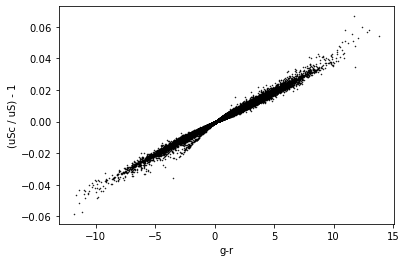

In [10]:
cut = (clauds['uS'] > 0.0) & (clauds['g'] > 0.0) & (clauds['r'] > 0.0)

pl.plot(clauds['g'][cut] - clauds['r'][cut], (clauds['uSc'][cut] / clauds['uS'][cut]) - 1.0, marker='.', lw=0.0, markersize=1, c='k')

pl.xlabel('g-r')
pl.ylabel('(uSc / uS) - 1')

In [12]:
tomog_lbg, tomog_lbg1, tomog_lbg2 = select_tomog(clauds, components=True)

print(len(tomog_lbg) / 1.e4, len(tomog_lbg1) / 1.e4, len(tomog_lbg2) / 1.e4)

Number of failures: 7628
0.7722 0.2219 0.2484


In [13]:
# Old length: 2582606
tomog

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,uSc,uW,uW_err
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64
2862416,149.45108189679198,2.4959045378684035,9812,"0,5",0,31,True .. True,0.00012352636,0.00011879271,4.0,-2.0909994,1.0399065,0.038375147,0.018295180545303717,0.00019551464,24.12787,0.9559721,0.9394374,1.3868651,1.8015153,-99.0,-99.0,25.539,25.648,24.663,24.457,24.441,24.369,24.454,24.515,24.578,24.256,24.621,-99.0,-99.0,0.045,0.062,0.015,0.016,0.018,0.026,0.058,0.028,0.038,0.035,0.071,25.777063,25.883532,24.880026,24.656193,24.627378,24.546331,24.62789,24.687494,24.743994,24.41672,24.777296,0.04525757,0.0625,0.014709473,0.015586853,0.017868042,0.026229858,0.058258057,0.02809143,0.03781128,0.035339355,0.07116699,25.75788,25.767439,24.715134,24.543142,24.523144,24.46837,24.560291,24.552223,24.559288,24.205591,24.590145,0.06652832,0.08428955,0.018859863,0.020996094,0.024368286,0.036499023,0.082214355,0.03717041,0.04788208,0.043640137,0.089904785,-0.15008685629179738,-0.023740782825899576,2047.0,-10.308,-10.735,-11.526,-11.792,-12.361,-12.507,-12.528,-12.496,-12.627,-12.637,-12.552,-12.911,-12.37,0.0568,0.0568,-99.0,-99.0,11,11.9809,65.1639,17.9031,1,237,1,-99.0,-99.0,-99.0,-99.0,0.0,0.0568,0.0568,1,508801000.0,0.0,0,510

In [14]:
print('Target density of tomog galaxies per sq. deg. is {:.2f}'.format(len(tomog) / area['u']))

Target density of tomog galaxies per sq. deg. is 2817.46


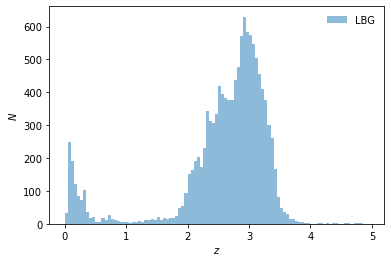

In [15]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog['Z_BEST'], bins=bins, alpha=0.5, label='LBG')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

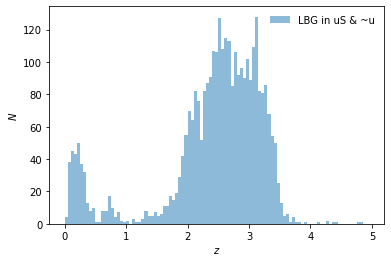

In [16]:
bins = np.arange(0.0, 5.0, 0.05)

# uS and not u for the worst imaging, u ~ 25.7-26.0;
cut  = (tomog['FLAG_FIELD_BINARY'][:,2] == True) & (tomog['FLAG_FIELD_BINARY'][:,1] == False)

pl.hist(tomog['Z_BEST'][cut], bins=bins, alpha=0.5, label='LBG in uS & ~u')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

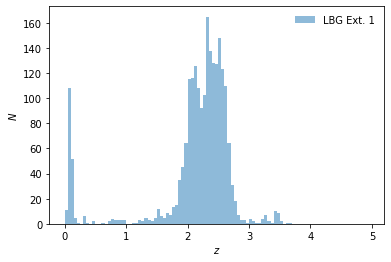

In [19]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg1['Z_BEST'], bins=bins, alpha=0.5, label='LBG Ext. 1')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [20]:
print(len(tomog_lbg1), np.count_nonzero(tomog_lbg1['Z_BEST'] < 1.5))

2219 237


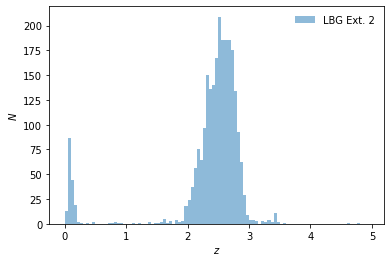

In [21]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(tomog_lbg2['Z_BEST'], bins=bins, alpha=0.5, label='LBG Ext. 2')

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [22]:
print(len(tomog_lbg2), np.count_nonzero(tomog_lbg2['Z_BEST'] < 1.5))

2484 192


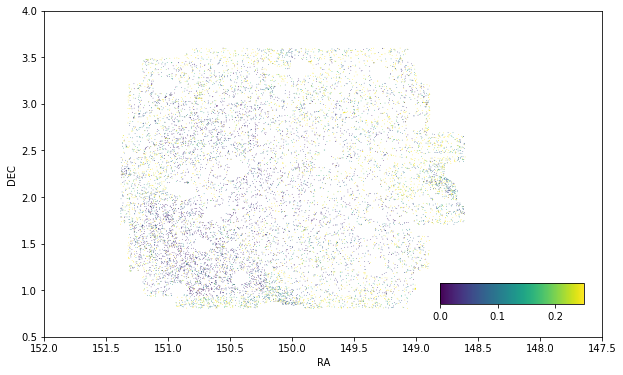

In [30]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(tomog['RA'], tomog['DEC'], c=tomog['uW_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.675, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

pl.savefig('plots/clauds_tomog_field.pdf')

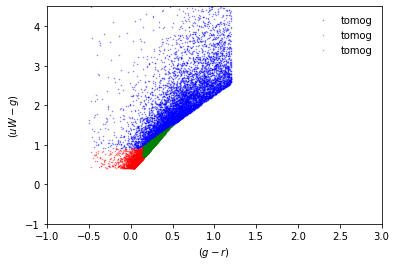

In [31]:
pl.plot( tomog_lbg['g'] - tomog_lbg['r'],   tomog_lbg['uW'] - tomog_lbg['g'],  marker='.', c='b', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg1['g'] - tomog_lbg1['r'], tomog_lbg1['uW'] - tomog_lbg1['g'], marker='.', c='r', lw=0.0, label='tomog', alpha=0.5, markersize=1)
pl.plot(tomog_lbg2['g'] - tomog_lbg2['r'], tomog_lbg2['uW'] - tomog_lbg2['g'], marker='.', c='g', lw=0.0, label='tomog', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(uW-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-tomog-selection.pdf')

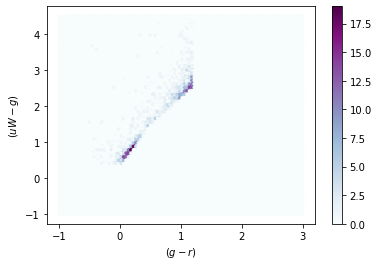

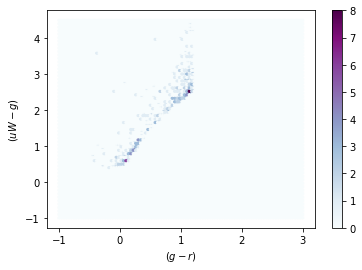

In [32]:
zmax  = 1.5

nocut = np.ones(len(tomog), dtype=bool)
cut   = (tomog['FLAG_FIELD_BINARY'][:,2] == True) & (tomog['FLAG_FIELD_BINARY'][:,1] == False)

for x in [nocut, cut]:
    interloper = tomog[x][tomog[x]['Z_BEST'] < zmax]

    # mincnt=10.0
    plt.hexbin(interloper['g'] - interloper['r'], interloper['uW'] - interloper['g'], extent=[-1., 3., -1., 4.5], cmap='BuPu')
    pl.colorbar()

    pl.xlabel(r'$(g -r)$')
    pl.ylabel(r'$(uW-g)$')
    pl.show()

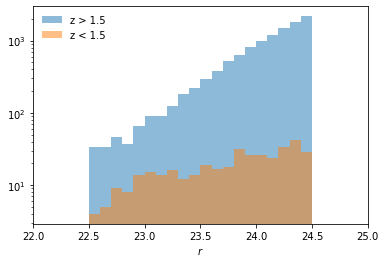

In [36]:
bins = np.arange(18., 26., 0.1)

interloper = tomog[tomog['Z_BEST'] < zmax]
high = tomog[tomog['Z_BEST'] > zmax]

cut  = (tomog['Z_BEST'] > zmax)
pl.hist(tomog['r'][cut], bins=bins, label='z > 1.5', alpha=0.5)

cut  = (interloper['FLAG_FIELD_BINARY'][:,2] == True) & (interloper['FLAG_FIELD_BINARY'][:,1] == False)
pl.hist(interloper['r'][cut], bins=bins, label='z < 1.5', alpha=0.5)

pl.xlim(22., 25.)

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [39]:
tomog['ID']

2862416
2486372
3530382
2723148
234884
826252
817459
2706581
2445240
3046006
4250278


# Done.